In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
import numpy as np
from sklearn.datasets import make_classification
from torch.autograd import Variable
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import pdb 

In [2]:
def cov_x_y(x,y):
    y = y.view(-1,1)  #tensor增加第二维的方法
    x_y = torch.cat((y,x),dim=1) #torch.cat((a,b),0)就是横着拼，得保证列维度相同，所以0就是表示改变的是第一个维度；同理，torch((a,b),1)就是竖着拼，改变的是第二个维度
    #a=torch.diag_embed(torch.rand(x_y.shape[1]))
    result=cov(x_y)
    #print(result)
    return result

In [3]:
def cov(x, rowvar=False, bias=False, ddof=None, aweights=None):
    """Estimates covariance matrix like numpy.cov"""
    # ensure at least 2D
    if x.dim() == 1:
        x = x.view(-1, 1)

    # treat each column as a data point, each row as a variable
    if rowvar and x.shape[0] != 1:
        x = x.t()   #tensor.t()矩阵的转置

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    w = aweights
    if w is not None:
        if not torch.is_tensor(w):
            w = torch.tensor(w, dtype=torch.float)
        w_sum = torch.sum(w)
        avg = torch.sum(x * (w/w_sum)[:,None], 0)
    else:
        avg = torch.mean(x, 0)  #torch.mean(x,0) 例子：[4,3]的矩阵对列求和取均值结果为[1,3]的矩阵

    # Determine the normalization
    if w is None:
        fact = x.shape[0] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof * torch.sum(w * w) / w_sum

    xm = x.sub(avg.expand_as(x))  # tensor下，a=b.sub(c)为a=b-c #x=x.expand_as(y)将x扩展为和y一样的维度  例子：如果x为大小为[1,3]的矩阵，y为[4,3]的矩阵，则拓展后x大小也为[4,3]，且同一列的数值都一样

    if w is None:
        X_T = xm.t()
    else:
        X_T = torch.mm(torch.diag(w), xm).t()

    c = torch.mm(X_T, xm)
    c = c / fact

    return c.squeeze() #tensor.squeeze()去掉维度中为1的维度 例子：大小为[1,2,1,3]会变为[2,3]

#协方差的求解步骤：(1)对x的每一列求均值   avg=torch.mean(x,0)
#               (2)对x的每一行减去均值   y=x.sub(avg.expand_as(x))
#               (3)cov=1/(m-1)*y.t()*y

In [4]:
def torch_von_Neumann_divergence(A,B):        
    #Divergence = np.trace(np.dot(A, logm(A)) - np.dot(A, logm(B)) - A + B)
    dev = A.device 
    
    A = A + torch.diag(torch.rand(A.size()[0],device=dev).uniform_(0.0000001, 0.00001))
    B = B + torch.diag(torch.rand(B.size()[0],device=dev).uniform_(0.0000001, 0.00001))


    Aeig_val, Aeig_vec = torch.symeig(A,True)    
    Beig_val, Beig_vec = torch.symeig(B,True)   
    
    Aeig_val, Beig_val = Aeig_val.abs(), Beig_val.abs()
    #A_val_temp, B_val_temp = Aeig_val.clone(), Beig_val.clone()

    z = torch.zeros(Aeig_val.shape, device=dev)
    o = torch.ones(Aeig_val.shape, device=dev)
    #Aeig_val = torch.where(Aeig_val<1e-7,z,Aeig_val)
    #Beig_val = torch.where(Beig_val<1e-7,z,Beig_val)
    A_val_temp, B_val_temp = Aeig_val.clone(), Beig_val.clone()
    A_val_temp = torch.where(A_val_temp<=0,o,A_val_temp) #torch.where合并o和A_Val_temp，即将A中小于等于0的元素用0代替
    B_val_temp = torch.where(B_val_temp<=0,o,B_val_temp)

    
    part1 = torch.sum(Aeig_val * torch.log(A_val_temp)   - Aeig_val + Beig_val) #矩阵的迹等于矩阵的特征值之和，对角矩阵的特征值等于对角线各元素
    lambda_log_theta = Aeig_val.unsqueeze(0).T *torch.log(B_val_temp.unsqueeze(0))
    part2 = (torch.matmul(Aeig_vec.T, Beig_vec)**2) * lambda_log_theta
    part2 = -part2.sum()

    Divergence = part1 + part2
    #print("time used for computing vm divergence {}".format(t2-t1))

    return Divergence

def loss_function_TRE(x,y_true,y_pred):
    #pdb.set_trace()
    cov_true = cov_x_y(x,y_true)
    cov_estimate = cov_x_y(x,y_pred)
    
    loss = torch_von_Neumann_divergence(cov_true,cov_estimate)+torch_von_Neumann_divergence(cov_estimate,cov_true)
    return loss

In [5]:
def train_generator(noise_rate,x_train,y_train):
    datasets = torch.utils.data.TensorDataset(x_train, y_train+noise_rate*torch.rand(y_train.size()))
    train_iter = torch.utils.data.DataLoader(datasets, batch_size=20, shuffle=False)
    return train_iter

In [20]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden_1= torch.nn.Linear(n_feature, 200)   # hidden layer
        self.hidden_2 = torch.nn.Linear(200, 100)   # output layer
        #self.hidden_3 = torch.nn.Linear(256, 128)
        #self.hidden_4 = torch.nn.Linear(128,64)
        #self.hidden_5 = torch.nn.Linear(64,32)
        #self.hidden_6 = torch.nn.Linear(32,10)
        self.predict = torch.nn.Linear(100,n_output)
        #self.bat_1=torch.nn.BatchNorm1d(256)
        #self.bat_2=torch.nn.BatchNorm1d(128)
        #self.bat_3=torch.nn.BatchNorm1d(64)
        self.do=torch.nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))# activation function for hidden layer
        x = F.relu(self.hidden_2(x))
        #x = F.relu(self.hidden_3(x))
        #x = F.relu(self.hidden_4(x))
        #x = F.relu(self.hidden_5(x))
        #x = F.relu(self.hidden_6(x))
        #x=self.do(x)
        x = self.predict(x)             # linear output
        return x

In [21]:
def main(data,labels,number,epochs,noise):
    #normalize the dataset
    mean=np.mean(data,0)
    std=np.std(data,0)
    data=(data-mean)/std
    x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=4)
    
    #transfer numpy to torch
    x_train=torch.from_numpy(x_train).float()
    y_train=torch.from_numpy(y_train).float()
    x_test=torch.from_numpy(x_test).float()
    y_test=torch.from_numpy(y_test).float()
    #define evaluation metrics
    loss_eva = torch.nn.MSELoss() 
    
    #create list to store the loss
    #loss_total_ours=[[0]*number for _ in range(len(noise))]
    loss_total_mse=[[0]*number for _ in range(len(noise))]
    #mean_loss_ours=[[0] for _ in range(len(noise))]
    mean_loss_mse=[[0] for _ in range(len(noise))]
    
    #training loop loss
    #training_loop_loss_ours=[]

    #training loop for ours
    #pdb.set_trace()
    """ for index in range(len(noise)):
        #%% von_Neumann divergence
        torch.manual_seed(4)
        net = Net(n_feature=x_train.shape[1], n_output=1)     # define the network
        print(net)  # net architecture
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        #loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

        for num in range(number):
            net.train()
            for epoch in range(epochs):
                for inputs,labels in train_generator(noise[index],x_train,y_train):
                    prediction = net(inputs)     # input x and predict based on x
                    loss = loss_function_TRE(inputs,labels,prediction.squeeze())   # must be (1. nn output, 2. target)
                    optimizer.zero_grad()   # clear gradients for next train
                    loss.backward()         # backpropagation, compute gradients
                    optimizer.step()        # apply gradients

            pred=net(x_train)
            bias = torch.mean(y_train - pred)
            #evaluate the performance on test dataset
            net.eval()
            test_prediction=net(x_test)+bias
            loss_total_ours[index][num]=loss_eva(y_test,test_prediction.squeeze()) """
            
    
    #get the mean loss over number       
    """ for row in range(len(noise)):
        mean_loss_ours[row]=torch.mean(torch.Tensor(loss_total_ours[row][:])) """

    #training loop for MSE
    for index in range(len(noise)):
        torch.manual_seed(4)  
        net_mse = Net(n_feature=x_train.shape[1], n_output=1)     # define the network
        print(net_mse)  # net architecture
        optimizer = torch.optim.Adam(net_mse.parameters(), lr=0.0005)
        loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

        train_loss=[]

        for num in range(number):
            net_mse.train()
            for epoch in range(epochs):
                losses=[]
                for inputs,labels in train_generator(noise[index],x_train,y_train):
                    prediction = net_mse(inputs)     # input x and predict based on x
                    #loss = loss_function(x,y,prediction)   # must be (1. nn output, 2. target)
                    loss = loss_func(prediction.squeeze(),labels)
                    optimizer.zero_grad()   # clear gradients for next train
                    loss.backward()         # backpropagation, compute gradients
                    optimizer.step()        # apply gradients
                    losses+=[loss.item()]
                train_loss.append(np.mean(losses))
            

            #evaluate the performance on test dataset
            net_mse.eval()
            test_prediction=net_mse(x_test)
            loss_total_mse[index][num]=loss_eva(y_test,test_prediction.squeeze())
            
            print("final epoch loss:{}".format(train_loss[-1]))
            plt.plot(np.linspace(0,200,200),train_loss,'b-',lw=2,label="training loss")
            plt.show()
            
            """ plt.plot(np.linspace(0,89,89),test_prediction.detach().numpy(),'b-',lw=2,label='prediction') #89
            plt.scatter(np.linspace(0,89,89),y_test.detach().numpy(),label='ground_truth')
            plt.xlabel('data')
            plt.ylabel('value')
            plt.legend()
            plt.show() """

            """ pred=net_mse(x_train)
            plt.plot(np.linspace(0,353,353),pred.detach().numpy(),'b-',lw=2,label='prediction') #353
            plt.scatter(np.linspace(0,353,353),y_train.detach().numpy(),label='ground_truth')
            plt.xlabel('data')
            plt.ylabel('value')
            plt.legend()
            plt.show() """
    #get the mean loss over number
    for row in range(len(noise)):
        mean_loss_mse[row]=torch.mean(torch.Tensor(loss_total_mse[row][:]))
    
    print("loss on test:{}".format(mean_loss_mse))
    #plot comparsion of Ours and MSE
    #plt.plot(noise,mean_loss_ours,'b-',lw=2,label='Ours',marker='o',markerfacecolor='gray',markersize=10)
    plt.plot(noise,mean_loss_mse,'r--',lw=2,label='MSE',marker='^',markerfacecolor='white',markersize=10)
    plt.xlabel('noise_level',{'size':15})
    plt.ylabel('performance(MSE)',{'size':15})
    plt.legend(prop={'size':20})
    plt.yticks(fontproperties = 'Times New Roman', size = 15)
    plt.xticks(fontproperties = 'Times New Roman', size = 15)
    plt.ioff()
    plt.show() 
    print('end') 

In [8]:
x,y=load_diabetes(return_X_y=True)

In [9]:
#noise_rate_choice=[-10,-8,-6,-4,-2,0,2,4,6,8,10]
noise_rate_choice=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
#oise_rate_choice=[0]

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2329.8467644585503


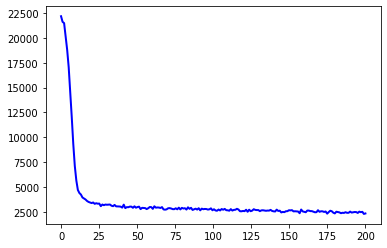

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2250.3779975043403


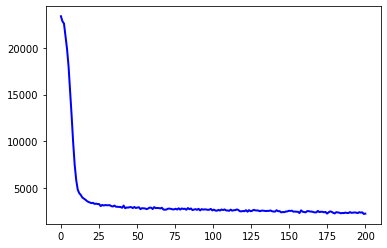

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2218.6685858832466


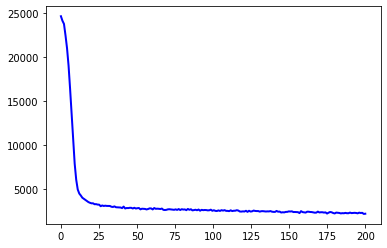

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2212.420857747396


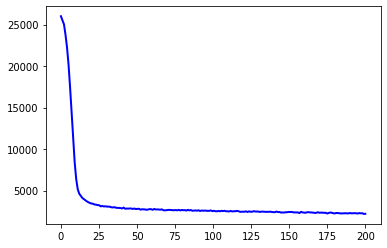

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2216.1295505099824


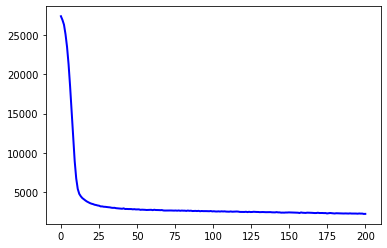

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2220.530320909288


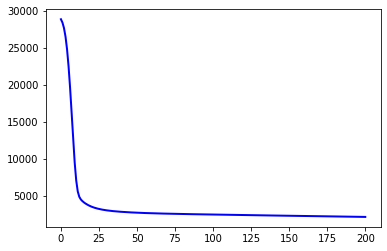

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2269.9322509765625


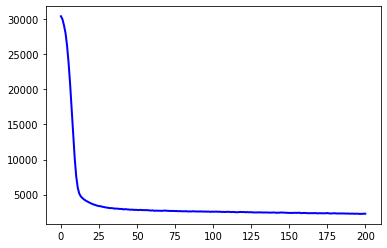

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2325.850389268663


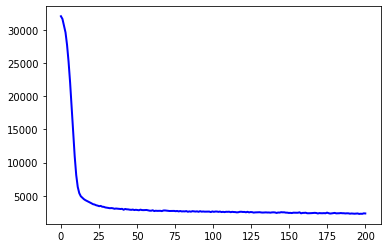

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2405.7567613389756


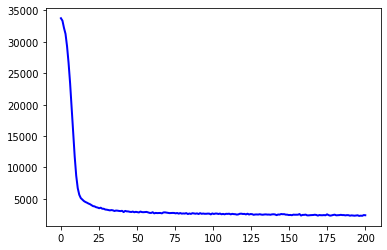

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2505.559563530816


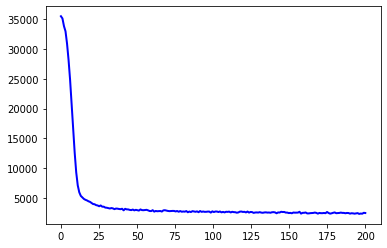

Net(
  (hidden_1): Linear(in_features=10, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)
final epoch loss:2570.437445746528


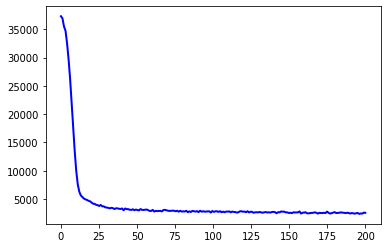

loss on test:[tensor(4155.7695), tensor(3940.3928), tensor(3739.6538), tensor(3532.4023), tensor(3427.4329), tensor(3375.2891), tensor(3371.8652), tensor(3421.1833), tensor(3492.7996), tensor(3608.0378), tensor(3791.0369)]


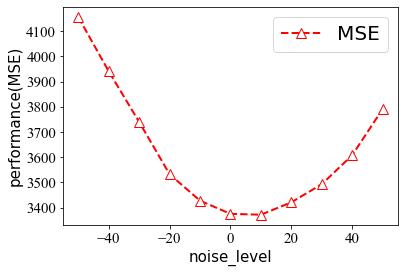

end


In [22]:
main(x,y,1,200,noise_rate_choice)